思路：数据探索，做一点点的修改-->数据清洗(空值的填充)-->数据预处理（数据的归一化，标准化等）-->模型构建-->训练预测-->保存提交

## 导入相应的包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as ppf
import warnings##忽略警告
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

这里需要导入一些包，用来做特征工程的

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder#标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler#去除异常值与数据标准化
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
# from sklearn.preprocessing import Imputer
import sys

## 检视原数据

In [3]:
train = pd.read_csv("./train.csv")

In [4]:
test = pd.read_csv("./test.csv")

In [5]:
train.head()#默认显示前五行

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


这样子大家应该一眼就能看出哪些是需要处理的吧

## 数据探索性分析 pandas_profiling

In [7]:
ppf.ProfileReport(train)

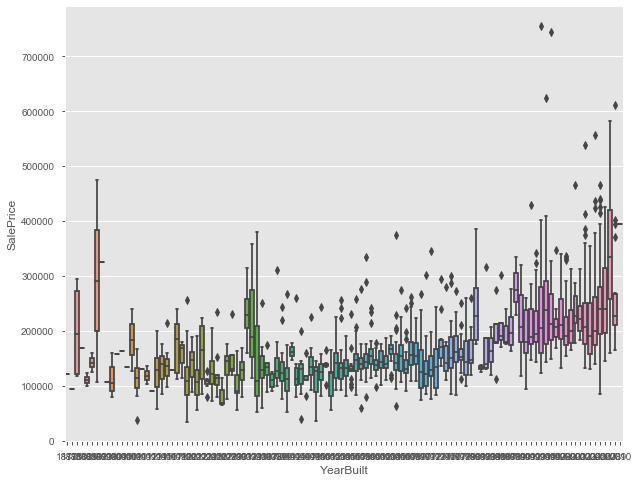

In [8]:
plt.figure(figsize=(10,8))
sns.boxplot(train.YearBuilt, train.SalePrice)##箱型图是看异常值的，离群点

(0, 800000)

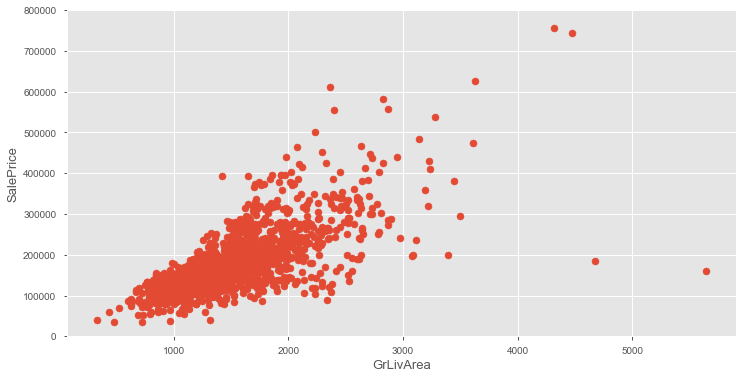

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)##可以用来观察存在线型的关系
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [10]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)#pandas 里面的条件索引

In [11]:
full = pd.concat([train,test],ignore_index=True)

In [12]:
full.drop("Id",axis=1,inplace=True)

In [13]:
full.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [14]:
# full.info()#查看数据的一个信息

# 数据清洗--空值填充、空值的删除，不处理

In [15]:
##查看缺失值，并且缺失的个数要从高到低排序

In [16]:
miss = full.isnull().sum()#统计出空值的个数

In [17]:
miss[miss>0].sort_values(ascending=True)#由低到高排好序

GarageArea         1
SaleType           1
KitchenQual        1
BsmtFinSF1         1
BsmtFinSF2         1
GarageCars         1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
BsmtUnfSF          1
Electrical         1
Functional         2
Utilities          2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtCond          82
BsmtExposure      82
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageQual       159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2346
Alley           2719
MiscFeature     2812
PoolQC          2908
dtype: int64

In [18]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
1stFlrSF         2917 non-null int64
2ndFlrSF         2917 non-null int64
3SsnPorch        2917 non-null int64
Alley            198 non-null object
BedroomAbvGr     2917 non-null int64
BldgType         2917 non-null object
BsmtCond         2835 non-null object
BsmtExposure     2835 non-null object
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtFinType1     2838 non-null object
BsmtFinType2     2837 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2836 non-null object
BsmtUnfSF        2916 non-null float64
CentralAir       2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
Electrical       2916 non-null object
EnclosedPorch    2917 non-null int64
ExterCond        2917 non-null object
ExterQual        2917 non-null object
Exterior1st      291

## 空值的填充与删除

对字符类型的进行填充

In [19]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None",inplace=True)

对数值类型的进行填充

In [20]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

对lotfrontage的空值进行填充（用这一列的均值）

In [21]:
full["LotFrontage"].fillna(np.mean(full["LotFrontage"]),inplace=True)

对这些列进行众数填充

In [22]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

查看哪些是还没填充好的，发现只有test的没有标签列

In [23]:
full.isnull().sum()[full.isnull().sum()>0]##至此我们已经把空值填充好了

SalePrice    1459
dtype: int64

## 数据预处理--字符变成数值型这是很重要的

将一些数字特征转换为类别特征。最好使用LabelEncoder和get_dummies来实现这些功能。

In [24]:
full["MSZoning"].mode()[0]

'RL'

In [25]:
for col in cols2:
    full[col]=full[col].astype(str)##astype来进行数据转换成字符串类型

In [26]:
lab = LabelEncoder()

In [27]:
full["Alley"] = lab.fit_transform(full.Alley)
full["PoolQC"] = lab.fit_transform(full.PoolQC)
full["MiscFeature"] = lab.fit_transform(full.MiscFeature)
full["Fence"] = lab.fit_transform(full.Fence)
full["FireplaceQu"] = lab.fit_transform(full.FireplaceQu)
full["GarageQual"] = lab.fit_transform(full.GarageQual)
full["GarageCond"] = lab.fit_transform(full.GarageCond)
full["GarageFinish"] = lab.fit_transform(full.GarageFinish)
full["GarageYrBlt"] = full["GarageYrBlt"].astype(str)
full["GarageYrBlt"] = lab.fit_transform(full.GarageYrBlt)
full["GarageType"] = lab.fit_transform(full.GarageType)
full["BsmtExposure"] = lab.fit_transform(full.BsmtExposure)
full["BsmtCond"] = lab.fit_transform(full.BsmtCond)
full["BsmtQual"] = lab.fit_transform(full.BsmtQual)
full["BsmtFinType2"] = lab.fit_transform(full.BsmtFinType2)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)
full["MasVnrType"] = lab.fit_transform(full.MasVnrType)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)

In [28]:
full.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [29]:
full["MSZoning"] = lab.fit_transform(full.MSZoning)
full["BsmtFullBath"] = lab.fit_transform(full.BsmtFullBath)
full["BsmtHalfBath"] = lab.fit_transform(full.BsmtHalfBath)
full["Utilities"] = lab.fit_transform(full.Utilities)
full["Functional"] = lab.fit_transform(full.Functional)
full["Electrical"] = lab.fit_transform(full.Electrical)
full["KitchenQual"] = lab.fit_transform(full.KitchenQual)
full["SaleType"] = lab.fit_transform(full.SaleType)
full["Exterior1st"] = lab.fit_transform(full.Exterior1st)
full["Exterior2nd"] = lab.fit_transform(full.Exterior2nd)

In [30]:
full.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,...,8,0,Pave,8,856.0,0,0,2003,2003,2008
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,8,0,Pave,6,1262.0,0,298,1976,1976,2007
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,8,0,Pave,6,920.0,0,0,2001,2002,2008
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,...,8,0,Pave,7,756.0,0,0,1915,1970,2006
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,8,0,Pave,9,1145.0,0,192,2000,2000,2008


In [31]:
full.drop("SalePrice",axis=1,inplace=True)##删除

In [32]:
# full2 = pd.get_dummies(full)##独热编码

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder#标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler#去除异常值与数据标准化
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
# from sklearn.preprocessing import Imputer

## <font color=red>管道建设：pipeline--方便组合各种特征以及对特征的处理，方便后续的机器学习的特征的重做</font>

<font color=blue >https://blog.csdn.net/dss_dssssd/article/details/82824979 这是关于BaseEstimator，TransformerMixin 这两个类的说明</font>

个人试错经历：

数据预处理阶段：为了省事，然后把空值都删掉了（现在想起来真的丢人）

特征工程阶段：没有进行特征的组合以及特征的选择，处理完就直接放到模型里面去训练

模型的一个选择阶段：对于数据的理解不是很深刻，就单纯的采用一种单一的模型（当然这里除了kaggle神器xgb、lightgbm等等之外。）


In [34]:
##自己写一个转换函数
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    ##对三个年份来进行一个标签编码,这里可以随便自己添加
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        X["BldgType"] = lab.fit_transform(X["BldgType"])
        
        return X

In [35]:
#转换函数
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):#偏度
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])#而是去除了包含了对象数据类型，取出来绝大部分是数值型
        skewness = X_numeric.apply(lambda x: skew(x))#匿名函数，做成字典的形式
        skewness_features = skewness[abs(skewness) >= self.skew].index#通过条件来涮选出skew>=0.5的索引的条件，取到了全部数据，防止数据的丢失
        X[skewness_features] = np.log1p(X[skewness_features])#求对数，进一步让他更符合正态分布
        X = pd.get_dummies(X)##一键独热，独热编码，（试错经历）
        return X

In [36]:
# 构建管道
pipe = Pipeline([##构建管道的意思
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=2)),
    ])

In [37]:
# 保存原来的数据以备后用，为了防止写错
full2 = full.copy()

In [38]:
pipeline_data = pipe.fit_transform(full2)

In [39]:
pipeline_data.shape

(2917, 178)

In [40]:
pipeline_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Street_Grvl,Street_Pave
0,856,854,0.0,1,3,0.0,1.609438,3,706.0,0.0,...,0,0,0,0,0,0,1,0,0,1
1,1262,0,0.0,1,3,0.0,1.609438,1,978.0,0.0,...,0,0,0,0,0,0,1,0,0,1
2,920,866,0.0,1,3,0.0,1.609438,2,486.0,0.0,...,0,0,0,0,0,0,1,0,0,1
3,961,756,0.0,1,3,0.0,0.693147,3,216.0,0.0,...,0,0,1,0,0,0,0,0,0,1
4,1145,1053,0.0,1,4,0.0,1.609438,0,655.0,0.0,...,0,0,0,0,0,0,1,0,0,1


In [41]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

## <font color= red> 特征的选择--基于特征重要性图来选择</font>

In [42]:
from sklearn.linear_model import Lasso##运用算法来进行训练集的得到特征的重要性，特征选择的一个作用是，wrapper基础模型
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [43]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=pipeline_data.columns)#索引和重要性做成dataframe形式

In [44]:
FI_lasso.sort_values("Feature Importance",ascending=False)#由高到低进行排序

,Feature Importance
GrLivArea,0.124653
OverallQual,0.070760
YearBuilt,0.054572
TotalBsmtSF,0.045606
OverallCond,0.044655
...,...
Neighborhood_MeadowV,-0.013843
Neighborhood_OldTown,-0.013855
Neighborhood_IDOTRR,-0.014938
CentralAir_N,-0.016365


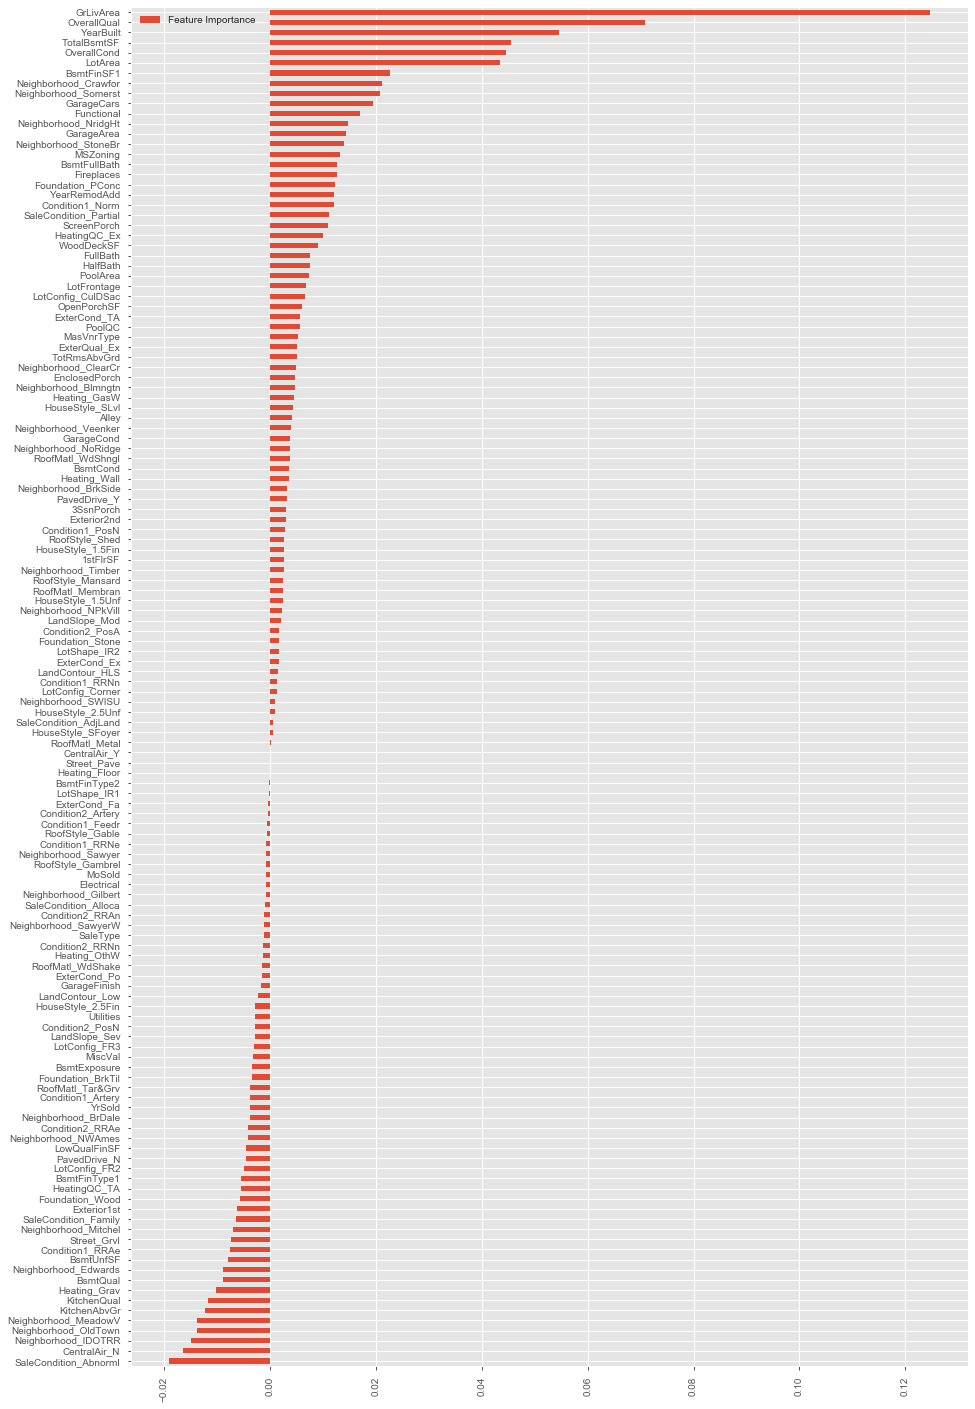

In [45]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()##画图显示

## <font color=red> 得到特征重要性图之后就可以进行特征选择与重做,这里也提供一条其他的思路，特征不重要的要删除</font>

In [46]:
##大家的发挥空间比较大，可以随意的定制，自己做两种特征
class add_feature(BaseEstimator, TransformerMixin):#自己定义转换函数--fit_transform由自己定义
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            ###
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("Heating_Grav"))
            print('删除' + X.pop("KitchenQual"))
            print('删除' + X.pop("xxx"))
            print('删除' + X.pop("Neighborhood_MeadowV"))
            print('删除' + X.pop("Neighborhood_OldTown"))
            print('删除' + X.pop("Neighborhood_IDOTRR"))
            print('删除' + X.pop("CentralAir_N"))
            print('删除' + X.pop("SaleCondition_Abnorml"))

    
            return X

In [47]:
pipe = Pipeline([#把后面的东西加到管道里面来
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=4)),
    ])

In [48]:
pipe

Pipeline(memory=None,
         steps=[('labenc', labelenc()),
                ('add_feature', add_feature(additional=2)),
                ('skew_dummies', skew_dummies(skew=4))],
         verbose=False)

In [49]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

## 模型的构建

In [50]:
from sklearn.tree import DecisionTreeRegressor#导入模型

In [51]:
model = DecisionTreeRegressor()

In [52]:
model1 =model.fit(X_scaled,y_log)

## 模型训练好了后就对test进行预测

In [53]:
predict = np.exp(model1.predict(test_X_scaled))##np.exp是对上面的对数变换之后的反变换

In [54]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':predict})
result.to_csv("submission2.csv",index=False)